<a href="https://colab.research.google.com/github/marco10507/ml-portfolio/blob/main/stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

file_id = '1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'healthcare-dataset-stroke-data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AbKB9-FUmOwJpAipx8ij4V60eLvPRCKr
To: /content/healthcare-dataset-stroke-data.csv
100%|██████████| 317k/317k [00:00<00:00, 7.11MB/s]


'healthcare-dataset-stroke-data.csv'

In [2]:
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def get_feature_importances(model, feature_names, ascending=False):
    importances = model.feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=ascending)

    return feature_importances

def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot a normalized confusion matrix.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    class_names (list of str): List of class names.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()

def calcuale_optimal_threshold(tpr, fpr, thresholds):
  J = tpr - fpr
  optimal_idx = J.argmax()
  optimal_threshold = thresholds[optimal_idx]

  return (optimal_threshold, optimal_idx)

def plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx):
  # Plot ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.6f}')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()

def model_perfonance_evaluation(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  plot_normalized_confusion_matrix(y_test, y_pred, ['no stroke', 'stroke'])

def get_search_grid():
  gbm = GradientBoostingClassifier(random_state=42)

  param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample" : [0.8, 0.9, 1]
  }

  search_grid = GridSearchCV(param_grid=param_grid, estimator=gbm, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3)

  return search_grid

def get_search_grid_with_resampled():

  pipeline = Pipeline([
      ('smote', SMOTE(random_state=42)),
      ('model', GradientBoostingClassifier(random_state=42))
  ])

  param_grid = {
    "smote__k_neighbors": [3, 5, 7, 10],
    "model__n_estimators": [50, 100, 150],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__subsample" : [0.8, 0.9, 1]
  }

  search_grid = GridSearchCV(param_grid=param_grid, estimator=pipeline, cv=5, n_jobs=-1, scoring='roc_auc', verbose=3)

  return search_grid


stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv');
stroke_data.info()
stroke_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [3]:
print("gender unique values:", stroke_data['gender'].unique())
print("ever_married unique values:", stroke_data['ever_married'].unique())
print("work_type unique values:", stroke_data['work_type'].unique())
print("Residence_type unique values:", stroke_data['Residence_type'].unique())
print("smoking_status unique values:", stroke_data['smoking_status'].unique())

gender unique values: ['Male' 'Female' 'Other']
ever_married unique values: ['Yes' 'No']
work_type unique values: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type unique values: ['Urban' 'Rural']
smoking_status unique values: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [4]:
print(stroke_data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


In [5]:
print(stroke_data['stroke'].value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


In [6]:
stroke_data = pd.get_dummies(stroke_data, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [7]:
print(stroke_data.columns)

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'gender_Other',
       'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')


In [8]:
features = stroke_data.drop(columns=['id', 'stroke'])
target = stroke_data['stroke'];


X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train['bmi'] = imputer.fit_transform(X_train[['bmi']])
X_test['bmi'] = imputer.transform(X_test[['bmi']])

In [10]:
search_grid = get_search_grid()
search_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 0.9, 1]},
             scoring='roc_auc', verbose=3)

In [11]:
print("best params", search_grid.best_params_)
print("best score", search_grid.best_score_)

best params {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.9}
best score 0.8393541279308515


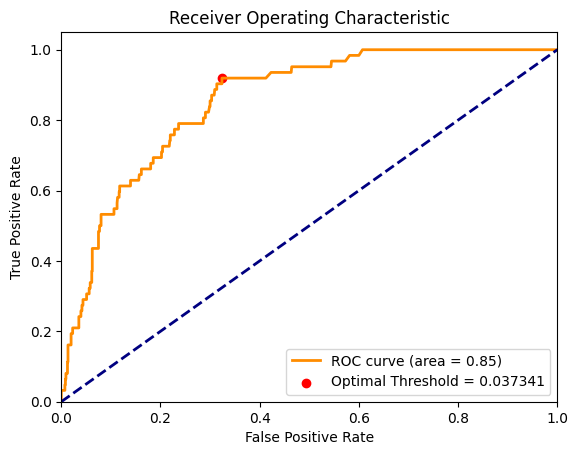

              precision    recall  f1-score   support

           0       0.99      0.68      0.80       960
           1       0.15      0.92      0.27        62

    accuracy                           0.69      1022
   macro avg       0.57      0.80      0.53      1022
weighted avg       0.94      0.69      0.77      1022



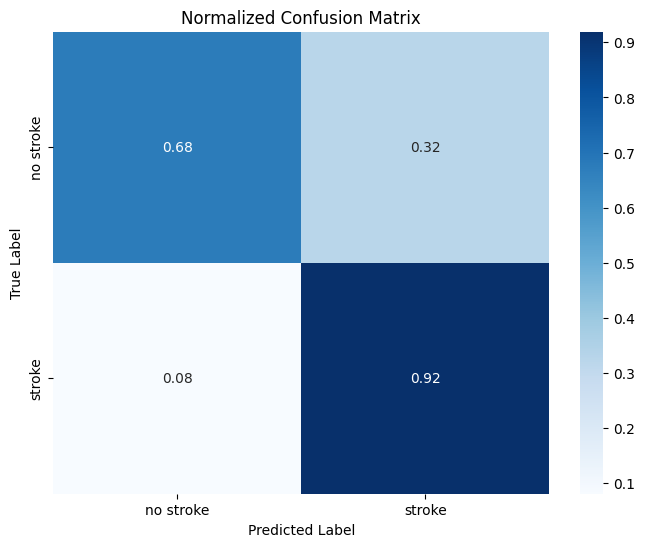

In [12]:
# Predict probabilities on the test set
y_probs = search_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

y_pred = (y_probs >= optimal_threshold).astype(int)

model_perfonance_evaluation(y_test, y_pred)

it seems that model learn to only detect people without strokes. I will performaing oversampling

In [13]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

search_grid = get_search_grid_with_resampled()
search_grid.fit(X_train, y_train)

X_train:  (4088, 21)
y_train:  (4088,)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('model',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.8, 0.9, 1],
                         'smote__k_neighbors': [3, 5, 7, 10]},
             scoring='roc_auc', verbose=3)

In [14]:
# print(get_feature_importances(search_grid.best_estimator_, X_train.columns))

In [15]:
print("train - best params", search_grid.best_params_)
print("train - best score", search_grid.best_score_)
# print(get_feature_importances(search_grid.best_estimator_, X_train_resampled.columns))

train - best params {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__subsample': 0.8, 'smote__k_neighbors': 10}
train - best score 0.8098534071662314


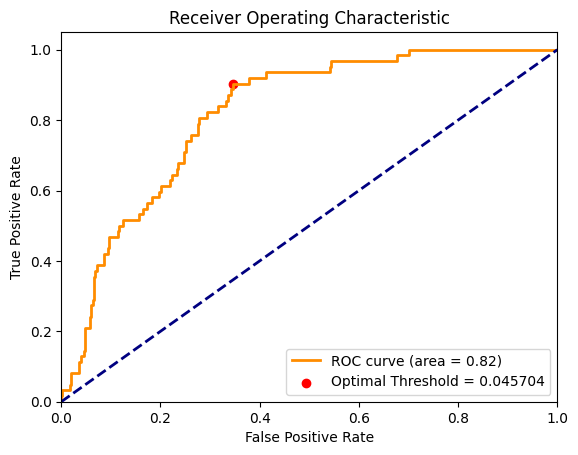

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       960
           1       0.14      0.90      0.25        62

    accuracy                           0.67      1022
   macro avg       0.57      0.78      0.52      1022
weighted avg       0.94      0.67      0.75      1022



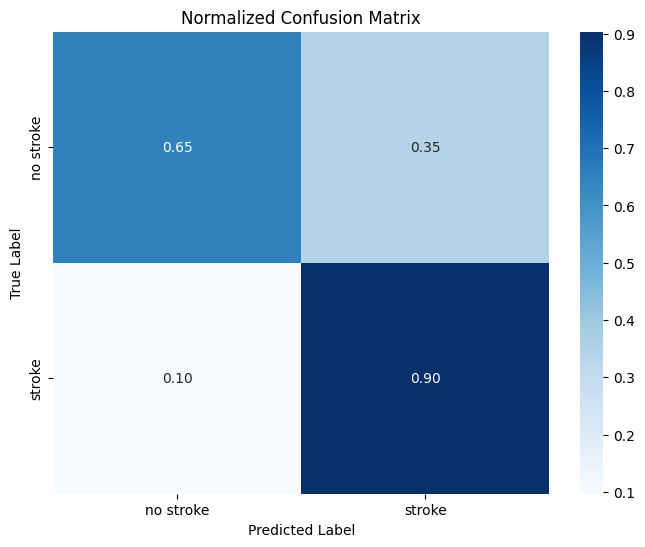

In [16]:
# Predict probabilities on the test set
y_probs = search_grid.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

y_pred = (y_probs >= optimal_threshold).astype(int)

model_perfonance_evaluation(y_test, y_pred)

I see that we are now overfitting the model. So I will perform feature selection to try to recude overfitting. I will only select the 4 best features based on the feature importance. Those features are: age, avg_glucose_level, bmi and smoking_status

In [17]:
selected_features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes', 'smoking_status_never smoked', 'smoking_status_formerly smoked', 'smoking_status_Unknown']
X_train_selection = X_train[selected_features]
X_test_selection = X_test[selected_features]

print('X_train_selection features: ', X_train_selection.columns)
print('X_test_selection features: ', X_test_selection.columns)

X_train_selection features:  Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes',
       'smoking_status_never smoked', 'smoking_status_formerly smoked',
       'smoking_status_Unknown'],
      dtype='object')
X_test_selection features:  Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_smokes',
       'smoking_status_never smoked', 'smoking_status_formerly smoked',
       'smoking_status_Unknown'],
      dtype='object')


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
train - best params {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 150, 'model__subsample': 0.8, 'smote__k_neighbors': 10}
train - best score 0.8212210585579747


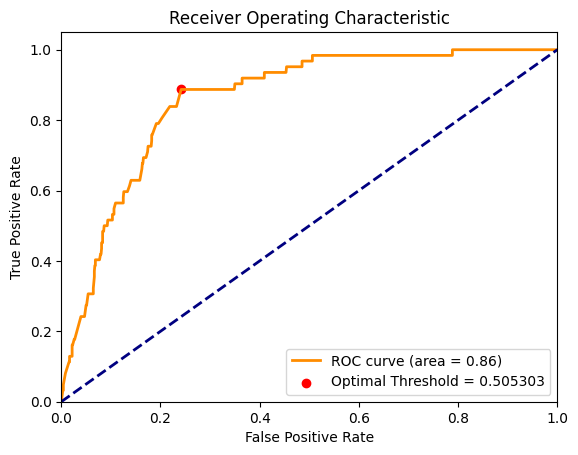

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       960
           1       0.19      0.89      0.32        62

    accuracy                           0.77      1022
   macro avg       0.59      0.82      0.59      1022
weighted avg       0.94      0.77      0.83      1022



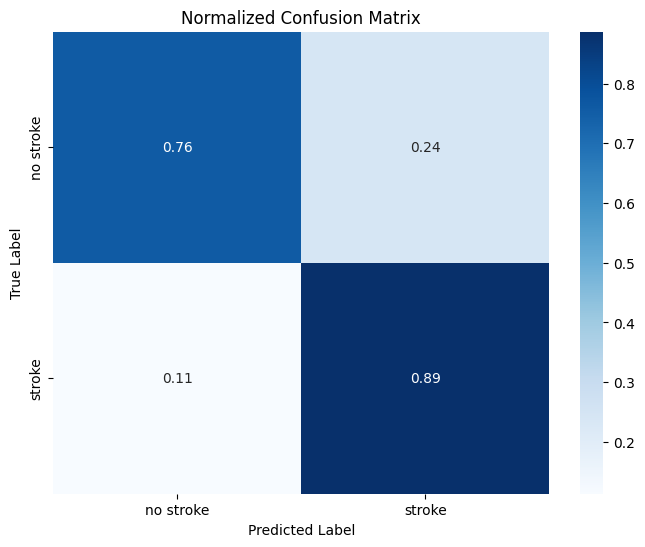

In [18]:
search_grid = get_search_grid_with_resampled()
search_grid.fit(X_train_selection, y_train)

print("train - best params", search_grid.best_params_)
print("train - best score", search_grid.best_score_)
# print(get_feature_importances(search_grid.best_estimator_, X_train_selection.columns))

y_probs = search_grid.predict_proba(X_test_selection)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

optimal_threshold, optimal_idx = calcuale_optimal_threshold(tpr, fpr, thresholds)
plot_roc_curve(fpr, tpr, roc_auc, optimal_threshold, optimal_idx)

y_pred = (y_probs >= optimal_threshold).astype(int)

model_perfonance_evaluation(y_test, y_pred)